# Clipboard Health - Case Study - By Jordan Porcu


## Abstract

In this case study, the main goal is to find the best tarification for a hail-riding company. Here are few informations we have :
>+ The ride is between Toledo Airport and Downtown.
>+ Two main people : "riders" are the ones who need a ride and "drivers" are the ones who conduct riders to destination.
>+ The study takes place for a full year only.

And here are the few constraints : 
>+ The company charges 30$ (fixed price) for the riders to take the ride.
>+ The number of rides asked by riders and accepted by drivers are determined following a Poisson distribution.
>+ The $\lambda$ factor of the Poisson distribution is equal 1 for the first month a rider enters the study. Then, it becomes the number of accepted rides for the next month, and so forth.
>+ Only 10,000 riders a year, and 1,000 riders a month

Finally, the goal here is to find the optimal tarification the company has to set for drivers, using informations, common sense and data analytics, respecting the constraints.

## Table of content 
* [Library importation](#library)
* [Data exploration](#data-exp)
* [Using external data](#external-data)
* [Settings](#settings)
* [Annual simulation](#annual-simulation)
* [Results interpretation](#interpretation)

## Library importation <a class="anchor" id="library"></a>

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

## Data exploration <a class="anchor" id="data-exp"></a>

Our first goal here is to find the relation between the pay offered to a driver and the probability he/she will accept to take the ride.
Let's clear the data first :

In [20]:
# Data importation
data = pd.read_csv("data.csv",index_col=0)
display(data.head(5))
# Are there NaNs ? 
data.isna().sum()

,PAY,ACCEPTED
0,29.358732,0
1,22.986847,0
2,18.020348,0
3,45.730717,1
4,14.642845,0


PAY         0
ACCEPTED    0
dtype: int64

No missing values, we now compute the outliers and we remove them to have a more precise study :

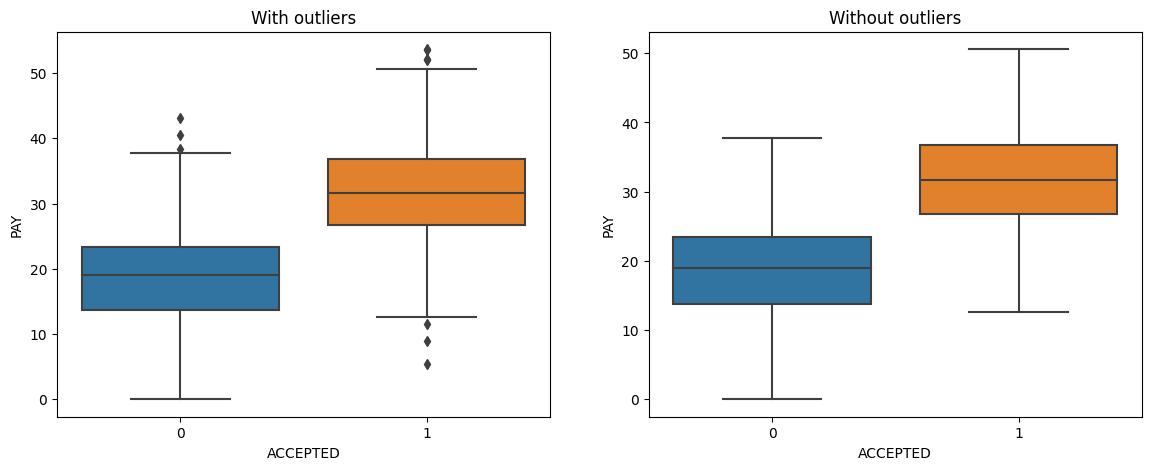

In [21]:
plt.figure(figsize=(14,5));

# Left plot : raw data (boxplot of accepted (or not) rides)
plt.subplot(121)
sns.boxplot(x="ACCEPTED",y="PAY",data=data);
plt.title("With outliers");

# Removal of values outside of "PAY" interquartile
for i in [0,1]:
    for x in ['PAY']:
        data_temp = data[data["ACCEPTED"]==i]
        q75,q25 = np.percentile(data_temp.loc[:,x],[75,25])
        intr_qr = q75-q25
    
        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)
    
        data_temp.loc[data_temp[x] < min,x] = np.nan
        data_temp.loc[data_temp[x] > max,x] = np.nan

        data[data["ACCEPTED"]==i] = data_temp

# Right plot : same boxplot without outliers
plt.subplot(122)
sns.boxplot(x="ACCEPTED",y="PAY",data=data);
plt.title("Without outliers");

Now the data is cleared, we can compute the relation between acceptance probability and pay :

Probability of accetping the ride : 0.91 for a 29 $ paid ride


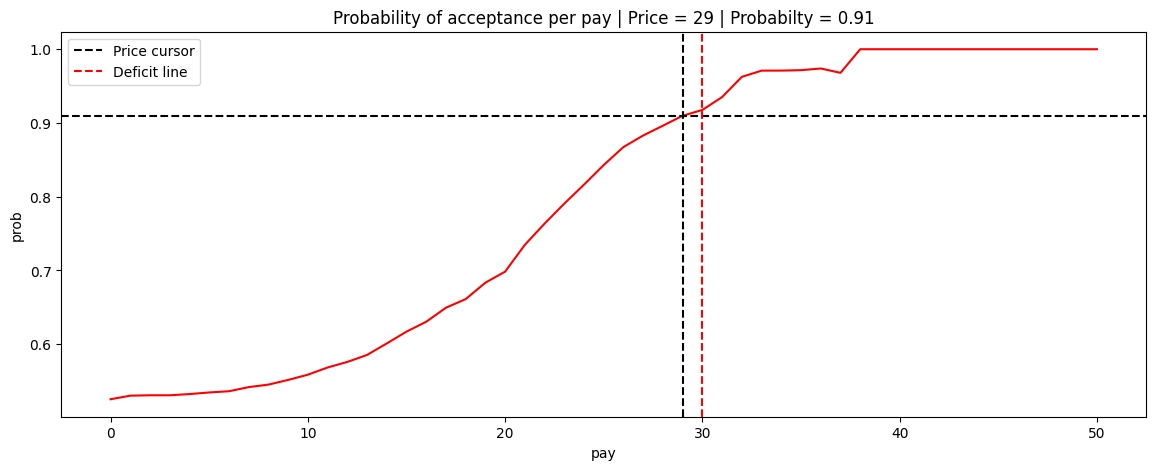

In [84]:
# Arbitrary price
price = 29

# Building x and y values : respectively pay and probability of accetpance associated
x_plot = []
y_plot = []
max_pay = data["PAY"].max()
for i in range(int(np.round(max_pay))):
    y = data[data["PAY"]>=i]["ACCEPTED"].mean()
    x_plot.append(i)
    y_plot.append(y)

# Creation of a dataframe with these values
dict_test = {"pay":x_plot,"prob":y_plot}
df = pd.DataFrame.from_dict(dict_test)

# Plotting 
plt.figure(figsize=(14,5));
sns.lineplot(x="pay",y="prob",data=df,color="red");
plt.axvline(x=price,linestyle="--",color="black");
plt.axhline(y=df["prob"][price],linestyle="--",color="black", label = "Price cursor");
plt.axvline(x=30,linestyle="--",color="red", label = "Deficit line")
plt.title("Probability of acceptance per pay | Price = " + str(price) + " | Probabilty = " + str(np.round(df["prob"][price],3)));
plt.legend(loc="best");
print(f'Probability of accetping the ride : {np.round(df["prob"][price],3)} for a {price} $ paid ride')

## Using external data <a class="anchor" id="external-data"></a>

Here we use data we found on internet to find the average salary a uber driver gets for the same job. The commentaries on the codes explains what we found, and the sources :

In [23]:
# three main source : Gasoline 9,000,000 / E85 875,000 / Diesel 199,000 in 2021
# https://afdc.energy.gov/states/OH

gas_price = 4.52 # $/gallon
e85_price = 3.97 # $/gallon
diesel_price = 5.50 # $/gallon

# distance toledo : airport - downtown (AD)
# https://www.google.com/maps

AD_time = 22 # minutes
AD_distance = 20.5 # miles

# moyenne consommation voitures
# https://www.kaggle.com/datasets/uciml/autompg-dataset

mpg_mean = 23 #miles/gallon

# uber driver salary median in ohio
# https://www.salary.com/tools/salary-calculator/uber-driver-hourly/oh

avg_salary = 18 # $/hour or pure benefit needed to match average salary
travel_salary = np.round(avg_salary*(AD_time/60),0)

# how much a ride (AD) costs to a driver

driver_cost = pd.DataFrame(columns=["gas","e85","diesel"]) # dataframe creation
driver_cost.loc["proportion",:] = [9000000,875000,199000] # proportion of uses

total_proportion = driver_cost.loc["proportion",:].sum() # total cases

driver_cost.loc["percent",:] = driver_cost.loc["proportion",:]/total_proportion # percentage of uses
driver_cost.loc["price",:] = [gas_price,e85_price,diesel_price] # mpg for uses
driver_cost.loc["travel_price",:] = (mpg_mean/AD_distance)*driver_cost.loc["price",:] # travel (22 min) price for drivers

# how much money we need to pay a driver to match average salary 

driver_cost.loc["travel_total_needed",:] = driver_cost.loc["travel_price",:]+travel_salary
driver_cost.loc["weighted_total",:] = driver_cost.loc["percent",:]*driver_cost.loc["travel_total_needed",:]

weighted_avg = np.round(driver_cost.loc["weighted_total"].sum(),1)
print(f'We need to pay {weighted_avg} $ minimum for a driver')

We need to pay 12.0 $ minimum for a driver


Now that we now that we can't pay a driver less than 12$ (otherwise, the company couldn't match competition) and not more than 30$ (negative profit), we can set few things we need to make our study :

## Settings <a class="anchor" id="settings"></a>

### Variables

In [24]:
# Maximum riders for a month
max_per_months = 1000
# Maximum riders for a year
max_per_year = 10000
# Optimal number of riders per month to smooth the riders number through the year
optimum_per_months = int(np.round(max_per_year/12))

### Functions

In [25]:
# Homemade factorial function
def factorial(n):
    fact = 1
    for i in range(1,n+1):
        fact *=i
    return fact

# Function that returns the probability of Poisson distribution returning k in depending on l (lambda) 
def poisson_prob(k,l):
    p = (l**k/factorial(k))*np.exp(-l)
    return p

# Function that returns repartition of set size by a Poisson distribution
def poisson_repart(l,size):
    return int(np.random.poisson(l,size))

# Function that returns the probability of acceptance of an input price
def get_prob_from_price(price):
    return df["prob"][price]

# Function that returns the number of accepted ride requests depending on number of asked requests
def is_accepted(request_number):
    if request_number != 0:
        n_accepted = 0
        for i in range(request_number):
            accepted_request = np.random.choice([0,1],p=[1-get_prob_from_price(price),get_prob_from_price(price)])
            n_accepted += accepted_request
        return n_accepted
    else:
        return 0

# Class that creates a rider
class Rider():
    def __init__(self,idx,request):
        self.idx = idx
        self.request = request
    
    def accepted(self):
        return is_accepted(self.request)

# Function that creates a month dataframe with index of riders, requests asked and accepted of each riders
def get_riders_for_a_month(n_riders):
    month1 = pd.DataFrame(columns=["idx","request","accepted"])
    n=1
    while len(month1)<n_riders:
        rider = Rider(n,poisson_repart(1,1))
        month1.loc[n-1,:] = [rider.idx,rider.request,rider.accepted()]
        n += 1
    return month1

# Function that returns a dictionary with total number of riders, accepted and asked requests and the potential profit according to the input price
def get_month_result(month,price):
    sum_accepted = month["accepted"].sum()
    sum_requests = month["request"].sum()
    potential_profit = sum_accepted*(30-price)
    result_dict = {"total_riders" : len(month), "accepted_requests" : sum_accepted, "total_requests": sum_requests, "potential_profit" : potential_profit }
    return result_dict

# Function that creates a new month according too the previous month (according to the constraints)
def new_month(previous_month):
    remaining = previous_month[previous_month["accepted"]!=0]
    new_riders_needed = optimum_per_months-len(remaining)

    new_riders = get_riders_for_a_month(new_riders_needed)

    new_month = pd.DataFrame(columns=["idx","request","accepted"])


    for idx,lbda in enumerate(remaining["accepted"]):
        new_month.loc[idx,"request"] = int(poisson_repart(lbda,1))

    for idx,item in enumerate(new_month["request"]):
        new_month.loc[idx,"accepted"] = int(is_accepted(item))

    new_month["idx"] = remaining.index
    final_month = pd.concat([new_month,new_riders])

    return final_month

# Function that creates 12 monthly results for a year
def get_each_month_created():
    for i in np.arange(1,13,1):
        if i == 1:
           globals()["month" + str(i)] =  get_riders_for_a_month(optimum_per_months)
        else:
            globals()["month" + str(i)] = new_month(globals()["month" + str(i-1)])
        
# Function that returns a dataframe with annual results according to the input price, and months created
def get_annual_results(price):
    annual_results = pd.DataFrame(columns=["riders","requests","accepted","profit"])

    for i in range(1,13):
        annual_results.loc[i,"riders"] = get_month_result(globals()["month" + str(i)],price)["total_riders"]
        annual_results.loc[i,"requests"] = get_month_result(globals()["month" + str(i)],price)["total_requests"]
        annual_results.loc[i,"accepted"] = get_month_result(globals()["month" + str(i)],price)["accepted_requests"]
        annual_results.loc[i,"profit"] = get_month_result(globals()["month" + str(i)],price)["potential_profit"]
    return annual_results

# Function that returns an array with price in a range of min-max price, and a second array with profit associated with each price
def get_profit():
    price_array = []
    price_profit = []
    min_price = int(weighted_avg)
    max_price = 30
    for it_price in tqdm(range(min_price,max_price)):
        price = it_price
        price_array.append(price)

        get_each_month_created()
        results = get_annual_results(price)

        price_profit.append(results["profit"].sum())
    return price_array,price_profit

# Function that uses price and profit arrays to compute a plot of profit and probability of acceptance per price, and a dictionnary of optimal price, probability and profit associated
def show_result(price_array,profit_array):
    scaler1 = MinMaxScaler()
    scaler2 = MinMaxScaler()

    x=price_array
    y1=np.array(profit_array)
    y2=np.array(get_prob_from_price(price_array))

    scaler1.fit(y1.reshape(-1,1))
    y1_scaled = scaler1.transform(y1.reshape(-1,1))

    scaler2.fit(y2.reshape(-1,1))
    y2_scaled = scaler2.transform(y2.reshape(-1,1))

    fig, ax1 = plt.subplots()

    ax1.set_xticks([i for i in range(12,30)])
    ax2 = ax1.twinx()
    sns.lineplot(x=x, y=y1,color="blue",ax=ax1)
    sns.lineplot(x=x, y=y2,ax=ax2,color="green")

    idx = np.argmin(abs(y1_scaled-y2_scaled))
    ax1.set_xlabel('Price')
    ax1.set_ylabel('Profit', color='g')
    ax2.set_ylabel('Probability', color='b')

    opt_price = x[idx]
    opt_profit = y1[idx]
    opt_prob = y2[idx]
    plt.axvline(x=opt_price,color="red");
    plt.title("Profit and probability of acceptance per driver price");
    plt.close()

    result_dict = {"price":opt_price, "prob":opt_prob, "profit":opt_profit}
    return fig,result_dict

## Annual simulation <a class="anchor" id="annual-simulation"></a>

Because through one year, results won't be meaningful, we compute 6 annual results, and we compute the mean of these results to get our optimal price : 

In [26]:
plots = []
final_results = pd.DataFrame(columns=["year","opt_price","opt_prob","opt_profit"])
for year in np.arange(1,7,1):
    print(f'{year}/{6}:')
    annual = get_profit()
    results = show_result(annual[0],annual[1])
    plots.append(results[0])

    year_result_df = pd.DataFrame.from_dict({"year":[year],
                    "opt_price":[results[1]["price"]],
                    "opt_prob":[results[1]["prob"]],
                    "opt_profit":[results[1]["profit"]]})
    final_results = pd.concat([final_results,year_result_df])
final_results.to_csv("results.csv")

1/6:


100%|██████████| 18/18 [00:57<00:00,  3.21s/it]


2/6:


100%|██████████| 18/18 [00:57<00:00,  3.20s/it]


3/6:


100%|██████████| 18/18 [00:57<00:00,  3.22s/it]


4/6:


100%|██████████| 18/18 [00:58<00:00,  3.23s/it]


5/6:


100%|██████████| 18/18 [01:03<00:00,  3.53s/it]


6/6:


100%|██████████| 18/18 [00:57<00:00,  3.19s/it]


Example of an annual result plot : 

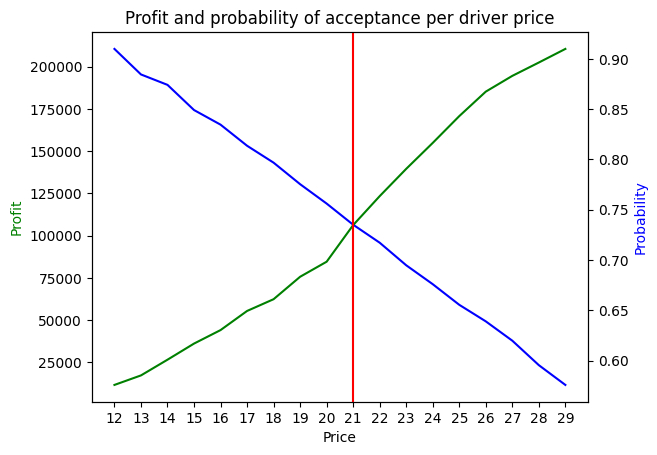

In [70]:
plots[0]

Here we can find the results of the 6 annual simulation :

In [27]:
final_results.mean()[1:].round(2)

opt_price         21.00
opt_prob           0.73
opt_profit    107119.50
dtype: float64

## Results interpretation <a class="anchor" id="interpretation"></a>

Through our study, we found that if we set our price (for drivers pay) at 21 $, it has the best balance between the probability the driver will accept the deal, and the profit the company makes with such a price a year.

But a question needs to be answered : Why such a balance ?

This comes from two major points : 

1. The higher the price, the higher the profit. So, if we set a price to 1 $, the company profit will be huge. And if we set a price to 29 $ (1$ profit), it will be very low. It seems obvious, but it makes much more sense considering the second point.

2. The company reputation from riders and drivers is an important key of success, and maintaining profits through the year. If we set price to a low value, profit will increase but not many drivers will accept the ride. Then, how a person will use the company application if most of it's rides are declined ? 

To find a compromise between a good profit, and a good reputation, this balance is needed.

As we said previously, a driver needs at least 5$ to make the ride profitable. Then, for a ride, the driver also needs 7$ more to match the average salary. Considering the given data, with a 21$ price, 3 drivers out of 4 will accept the ride, and will earn better than the average salary. Because customers satisfaction is important, this price seems to be correct, and still makes the company profitable (around 107,000$ a year)

However, few points can bias the results :
>+ Dependencie of Poisson distribution laws
>+ Only one dataset given, with only one feature
>+ Lack of information of what could make a driver accept or not
>+ No information of given data (source ? year ? country ? ride path ?)
>+ Data to have the average salary could have been more precised and not time-spreaded 

Finally, even if, intuitionously a 21$ seems correct, for a 9$ profit per ride, it needs to be taken with coutious, because of the biases it has.

If you have any suggestion on what could make this study better, or even raise a point of a mistake that could be made, don't hesitate to reach me at jordan.porcu@gmail.com.